## Katie Mears

# ADS 509 Module 3: Group Comparison

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
* Calculate descriptive statistics on the two sets of lyrics and compare the results.
* For each of the four corpora, find the words that are unique to that corpus.
* Build word clouds for all four corpora.

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
! pip install emoji
! pip install nltk

import nltk
nltk.download('stopwords')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [3]:
# Use this space for any additional import statements you need
# ! pip install wordcloud
from wordcloud import WordCloud
from matplotlib import pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# Place any addtional functions or constants you need here.

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA :
    for em in emoji.EMOJI_DATA[country] :
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    # Calculate the required statistics
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0.0

    # Count the most common tokens
    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(num_tokens)

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # Print the five most common tokens
        print("The most common tokens are:")
        for token, count in most_common_tokens:
            print(f"{token}: {count}")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]


def contains_emoji(s):

    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return [token for token in tokens if token.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    # modify this function to return tokens
    return [token for token in whitespace_pattern.split(text) if token]

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [78]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = data_location = "/content/drive/MyDrive/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [79]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t", quoting=3)
twitter_data['artist'] = "cher"



In [80]:
# print(twitter_data.head())

In [81]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])

del(twitter_data_2)

In [82]:
print(twitter_data.head())
print(twitter_data.tail())

    screen_name          name                   id        location  \
0        hsmcnp  Country Girl             35152213             NaN   
1    horrormomy          Jeny   742153090850164742           Earth   
2  anju79990584          anju  1496463006451974150             NaN   
3  gallionjenna             J           3366479914             NaN   
4       bcscomm       bcscomm             83915043  Washington, DC   

   followers_count  friends_count  \
0             1302           1014   
1               81            514   
2               13            140   
3              752            556   
4              888           2891   

                                         description artist  
0                                                NaN   cher  
1           𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜   cher  
2          163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡   cher  
3                                                csu   cher  
4  Writer @Washinformer @SpelmanCollege alumna

In [83]:
print(twitter_data['description'].head())

0                                                  NaN
1             𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2            163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3                                                  csu
4    Writer @Washinformer @SpelmanCollege alumna #D...
Name: description, dtype: object


In [84]:
# read in the lyrics here
# Path to the folder containing Lyrics Data
lyrics_folder_path = '/content/drive/MyDrive/M1 Results/lyrics'
lyrics_data = {}

# Iterate through each artist's folder in the main lyrics folder
for artist in os.listdir(lyrics_folder_path):
    artist_folder_path = os.path.join(lyrics_folder_path, artist)

    if os.path.isdir(artist_folder_path):
        lyrics_data[artist] = {}

        # Iterate through each song file in the artist's folder
        for song_file in os.listdir(artist_folder_path):
            song_path = os.path.join(artist_folder_path, song_file)

            if os.path.isfile(song_path) and song_file.endswith('.txt'):
                # Extract song title from the filename (remove .txt extension)
                song_title = song_file[:-4]

                # Read the lyrics within the with block
                with open(song_path, 'r') as file:
                    lyrics_data[artist][song_title] = file.read()


In [85]:
# Convert the lyrics_data dictionary to a DataFrame
lyrics_list = []

for artist, songs in lyrics_data.items():
    for song_title, lyrics in songs.items():
        lyrics_list.append({'Artist': artist,
                            'Song Title': song_title,
                            'Lyrics': lyrics})

lyrics_df = pd.DataFrame(lyrics_list)

# Display the DataFrame
print(lyrics_df.head())
print(lyrics_df.tail())

  Artist                   Song Title  \
0   cher  cher_youvemademesoveryhappy   
1   cher      cher_stillinlovewithyou   
2   cher                  cher_pirate   
3   cher                cher_darklady   
4   cher            cher_disastercake   

                                              Lyrics  
0  "You've Made Me So Very Happy"\n\n\n\nI've los...  
1  "Still In Love With You"\n\n\n\nVisions haunt ...  
2  "Pirate"\n\n\n\nHe'll sail on with the summer ...  
3  "Dark Lady"\n\n\n\nThe fortune queen of New Or...  
4  "Disaster Cake"\n\n\n\nIf you're gonna make an...  
    Artist              Song Title  \
415  robyn          robyn_herewego   
416  robyn    robyn_notontheinside   
417  robyn  robyn_everylittlething   
418  robyn          robyn_robotboy   
419  robyn     robyn_tomteverkstan   

                                                Lyrics  
415  "Here We Go"\n\n\n\nI couldn't wait another mi...  
416  "Not On The Inside"\n\n\n\nIsn't funny how som...  
417  "Every Little Thin

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning.

**Lyrics**

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions**

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.

In [86]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_df["tokens"] = lyrics_df["Lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_df["num_tokens"] = lyrics_df["tokens"].map(len)

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)


In [87]:
lyrics_df.head()

,Artist,Song Title,Lyrics,tokens,num_tokens
0,cher,cher_youvemademesoveryhappy,"""You've Made Me So Very Happy""\n\n\n\nI've los...","[youve, made, happy, ive, lost, love, got, mad...",83
1,cher,cher_stillinlovewithyou,"""Still In Love With You""\n\n\n\nVisions haunt ...","[still, love, visions, haunt, memory, hold, ho...",99
2,cher,cher_pirate,"""Pirate""\n\n\n\nHe'll sail on with the summer ...","[pirate, hell, sail, summer, wind, blows, day,...",144
3,cher,cher_darklady,"""Dark Lady""\n\n\n\nThe fortune queen of New Or...","[dark, lady, fortune, queen, new, orleans, bru...",131
4,cher,cher_disastercake,"""Disaster Cake""\n\n\n\nIf you're gonna make an...","[disaster, cake, youre, gonna, make, omelette,...",195


In [88]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [89]:
twitter_data[twitter_data.has_emoji].sample(5)[["artist","description","tokens"]]

,artist,description,tokens
2936044,cher,"Forever young ✌ Quotes, funny pictures and eve...","[forever, young, ✌, quotes, funny, pictures, e..."
1320101,cher,old soul🌿🌞,"[old, soul🌿🌞]"
409239,cher,Born and raised a proud Philly girl. Transplan...,"[born, raised, proud, philly, girl, transplant..."
162402,cher,"Actress, Music Maker, Photo taker, Newyorican ...","[actress, music, maker, photo, taker, newyoric..."
548646,cher,Melbourne | 18 ⛓ 3 Cats | Omegle Survivor Half...,"[melbourne, 18, ⛓, 3, cats, omegle, survivor, ..."


With the data processed, we can now start work on the assignment questions.

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Currently, the pipeline applies basic transformations like converting to lowercase, removing punctuation, and tokenizing based on whitespace. This approach may split meaningful phrases into individual tokens, losing context (for example, "lavender loving" becomes "lavender" and "loving"). Implementing a method to detect and retain multi-word phrases can enhance the richness of our analysis.

## Calculate descriptive statistics on the two sets of lyrics and compare the results.


In [90]:
# Function to calculate descriptive statistics for an artist
def calculate_descriptive_stats(lyrics):
    all_tokens = []
    for lyric in lyrics:
        tokens = lyric.split()
        all_tokens.extend(tokens)

    total_tokens = len(all_tokens)
    unique_tokens = len(set(all_tokens))
    total_characters = sum(len(token) for token in all_tokens)
    lexical_diversity = unique_tokens / total_tokens if total_tokens > 0 else 0

    # Calculate the most common tokens
    token_counts = Counter(all_tokens)
    most_common_tokens = token_counts.most_common(10)

    return {
        'total_tokens': total_tokens,
        'unique_tokens': unique_tokens,
        'total_characters': total_characters,
        'lexical_diversity': lexical_diversity,
        'most_common_tokens': most_common_tokens,
    }

# Calculate statistics for each artist
cher_lyrics = lyrics_df[lyrics_df['Artist'] == 'cher']['Lyrics']
robyn_lyrics = lyrics_df[lyrics_df['Artist'] == 'robyn']['Lyrics']

cher_stats = calculate_descriptive_stats(cher_lyrics)
robyn_stats = calculate_descriptive_stats(robyn_lyrics)

# Print the results
print("Cher's Descriptive Statistics:")
for key, value in cher_stats.items():
    print(f"{key}: {value}")

print("\nRobyn's Descriptive Statistics:")
for key, value in robyn_stats.items():
    print(f"{key}: {value}")

# Comparison
print("\nComparison:")
for key in cher_stats.keys():
    if key != 'most_common_tokens':  # Avoid printing the token lists for comparison
        print(f"{key} - Cher: {cher_stats[key]}, Robyn: {robyn_stats[key]}")

Cher's Descriptive Statistics:
total_tokens: 70097
unique_tokens: 6039
total_characters: 274296
lexical_diversity: 0.0861520464499194
most_common_tokens: [('I', 2649), ('you', 2211), ('the', 2131), ('to', 1534), ('a', 1230), ('me', 1222), ('my', 788), ('and', 784), ('love', 779), ('And', 778)]

Robyn's Descriptive Statistics:
total_tokens: 29318
unique_tokens: 3308
total_characters: 117270
lexical_diversity: 0.11283170748345726
most_common_tokens: [('you', 1216), ('I', 831), ('the', 811), ('me', 659), ('to', 640), ('it', 416), ('and', 385), ('a', 356), ('in', 330), ('my', 322)]

Comparison:
total_tokens - Cher: 70097, Robyn: 29318
unique_tokens - Cher: 6039, Robyn: 3308
total_characters - Cher: 274296, Robyn: 117270
lexical_diversity - Cher: 0.0861520464499194, Robyn: 0.11283170748345726


Q: what observations do you make about these data?

A: Robyn's lyrics have a higher lexical diversity (0.1416) compared to Cher's (0.1031), meaning her words are more varied. Robyn uses fewer total words (15,227) and unique words (2,156), while Cher has more total words (35,916) and unique words (3,703). Both artists frequently use words like "love," "I'm," and "don't." However, Cher repeats these words more often, especially "love," which appears 1,004 times, compared to Robyn's most common word, "know," which appears 308 times.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [91]:
n = 5  # Minimum frequency cutoff
corpora = {
    'Cher': lyrics_df[lyrics_df['Artist'] == 'cher']['tokens'].explode(),
    'Robyn': lyrics_df[lyrics_df['Artist'] == 'robyn']['tokens'].explode(),
    'Twitter_Cher': twitter_data[twitter_data['artist'] == 'cher']['tokens'].explode(),
    'Twitter_Robyn': twitter_data[twitter_data['artist'] == 'robyn']['tokens'].explode(),
}

# Calculate token counts and total length for each corpus
token_counts = {}
total_lengths = {}

for name, tokens in corpora.items():
    counts = Counter(tokens)
    token_counts[name] = counts
    total_lengths[name] = sum(counts.values())

# Calculate concentrations and concentration ratios
concentration_ratios = {}

for token in set.union(*(set(counts.keys()) for counts in token_counts.values())):
    ratios = {}
    for name in token_counts:
        if token in token_counts[name]:
            concentration = token_counts[name][token] / total_lengths[name]
            ratios[name] = concentration
    if all(ratio >= 0 for ratio in ratios.values()):
        max_corp = max(ratios, key=ratios.get)
        ratio_values = {k: v / ratios[max_corp] for k, v in ratios.items() if k != max_corp}
        concentration_ratios[token] = {**ratios, **{'max_corp': max_corp}, **ratio_values}

# Filter for tokens appearing at least n times in all corpora
filtered_ratios = {token: values for token, values in concentration_ratios.items()
                   if all(token_counts[corp].get(token, 0) >= n for corp in corpora)}

# Get top 10 tokens for each corpus based on concentration ratios
top_tokens = {}
for name in corpora:
    top_tokens[name] = sorted(
        [token for token, values in filtered_ratios.items() if values.get(name) is not None],
        key=lambda token: filtered_ratios[token][name], reverse=True
    )[:10]

# Display top tokens
for corpus, tokens in top_tokens.items():
    print(f"Top tokens for {corpus}: {tokens}")

Top tokens for Cher: ['world', 'miss', 'wind', 'ill', 'though', 'fall', 'tried', 'matter', 'ever', 'weve']
Top tokens for Robyn: ['feels', 'stronger', 'would', 'youll', 'two', 'sometimes', 'need', 'wanna', 'reason', 'talk']
Top tokens for Twitter_Cher: ['anything', 'things', 'making', 'black', 'crazy', 'new', 'friend', 'nice', 'simple', 'two']
Top tokens for Twitter_Robyn: ['working', 'making', 'black', 'since', 'big', 'best', 'live', 'news', 'people', 'old']


In [92]:
n = 5  # Minimum frequency cutoff
corpora = {
    'Cher': lyrics_df[lyrics_df['Artist'] == 'cher']['tokens'].explode(),
    'Robyn': lyrics_df[lyrics_df['Artist'] == 'robyn']['tokens'].explode(),
    'Twitter_Cher': twitter_data[twitter_data['artist'] == 'cher']['tokens'].explode(),
    'Twitter_Robyn': twitter_data[twitter_data['artist'] == 'robyn']['tokens'].explode(),
}

# Calculate token counts and total length for each corpus
token_counts = {}
total_lengths = {}

for name, tokens in corpora.items():
    counts = Counter(tokens)
    token_counts[name] = counts
    total_lengths[name] = sum(counts.values())

# Calculate concentrations and concentration ratios
concentration_ratios = {}

# Iterate over each unique token
for token in set.union(*(set(counts.keys()) for counts in token_counts.values())):
    ratios = {}
    for name in token_counts:
        if token in token_counts[name]:
            concentration = token_counts[name][token] / total_lengths[name]
            ratios[name] = concentration
    if all(ratio >= 0 for ratio in ratios.values()):
        max_corp = max(ratios, key=ratios.get)
        ratio_values = {k: v / ratios[max_corp] for k, v in ratios.items() if k != max_corp}
        concentration_ratios[token] = {**ratios, **{'max_corp': max_corp}, **ratio_values}

# Filter for tokens appearing at least n times in all corpora
filtered_ratios = {token: values for token, values in concentration_ratios.items()
                   if all(token_counts[corp].get(token, 0) >= n for corp in corpora)}

# Get top 10 tokens for each corpus based on concentration ratios
top_tokens = {}
for name in corpora:
    top_tokens[name] = sorted(
        [token for token, values in filtered_ratios.items() if values.get(name) is not None],
        key=lambda token: filtered_ratios[token][name], reverse=True
    )[:10]

# Display top tokens with their concentration ratios
for corpus, tokens in top_tokens.items():
    print(f"Top tokens for {corpus}:")
    for token in tokens:
        ratio_info = filtered_ratios[token]
        print(f"  Token: {token}, Concentration: {ratio_info[corpus]}, Ratio: {ratio_info}")



Top tokens for Cher:
  Token: world, Concentration: 0.994382346687726, Ratio: {'Cher': 0.994382346687726, 'Robyn': 0.0036120049911341694, 'Twitter_Cher': 0.6593333139338442, 'Twitter_Robyn': 0.5446037680808479, 'max_corp': 'Robyn'}
  Token: miss, Concentration: 0.9892434198314587, Ratio: {'Cher': 0.9892434198314587, 'Robyn': 0.0005910553621855914, 'Twitter_Cher': 0.37028882891727616, 'Twitter_Robyn': 0.2692171998296825, 'max_corp': 'Robyn'}
  Token: wind, Concentration: 0.9892434198314586, Ratio: {'Cher': 0.9892434198314586, 'Robyn': 0.0007880738162474552, 'Twitter_Cher': 0.05288815250233188, 'Twitter_Robyn': 0.044954192801748866, 'max_corp': 'Robyn'}
  Token: ill, Concentration: 0.9873075227280702, Ratio: {'Cher': 0.9873075227280702, 'Robyn': 0.004794115715505353, 'Twitter_Cher': 0.12067711754774559, 'Twitter_Robyn': 0.10671271585908529, 'max_corp': 'Robyn'}
  Token: though, Concentration: 0.9828197612611245, Ratio: {'Cher': 0.9828197612611245, 'Robyn': 0.0014448019964536677, 'Twitter

Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A: The top tokens from Cher and Robyn's lyrics show different themes. Cher’s words like “world” and “miss” express emotions and personal feelings, while Robyn’s words like “stronger” and “wanna” convey empowerment. In their Twitter data, both artists use casual words like “making,” reflecting a focus on creativity and connection with fans. Overall, Cher's lyrics are more about deep emotions, while Robyn's language is more direct and relatable. "Black" and "making" appears in the top tokens for both of their twitter data, which I thought was interesting. Also noted that "stronger" appeared in the top tokens for Robyn's lyrics and twitter data.

## Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.


In [93]:
# Define the wordcloud function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color="black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # Convert data frame into dict
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Filter stopwords in frequency counter
    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items()
                   if token not in stopwords}

    wc.generate_from_frequencies(counter)

    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Define function to count words
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # Transform counter into DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [94]:
# Count word frequencies for Cher's lyrics
cher_lyrics_freq = count_words(lyrics_df[lyrics_df['Artist'] == 'cher'], column='tokens', min_freq=5)

# Count word frequencies for Robyn's lyrics
robyn_lyrics_freq = count_words(lyrics_df[lyrics_df['Artist'] == 'robyn'], column='tokens', min_freq=5)

# Count word frequencies for Cher's Twitter descriptions
cher_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'cher'], column='tokens', min_freq=5)

# Count word frequencies for Robyn's Twitter descriptions
robyn_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'robyn'], column='tokens', min_freq=5)

Cher Lyrics Wordcloud:


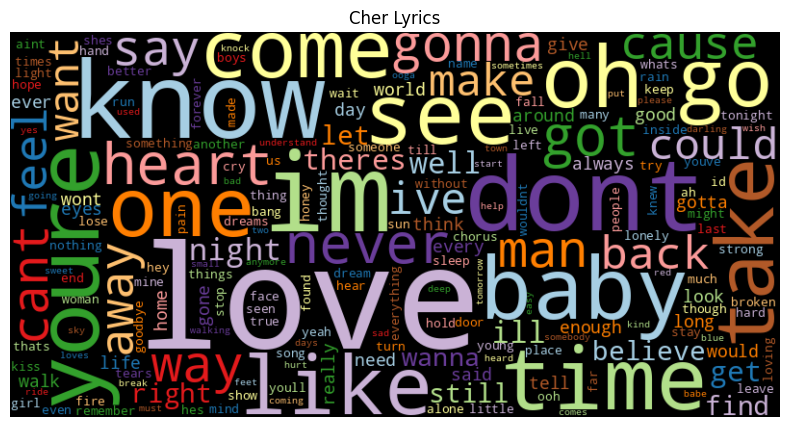

In [95]:
# Generate and display word clouds for each dataset
print("Cher Lyrics Wordcloud:")
wordcloud(cher_lyrics_freq['freq'], title="Cher Lyrics")

Robyn Lyrics Wordcloud:


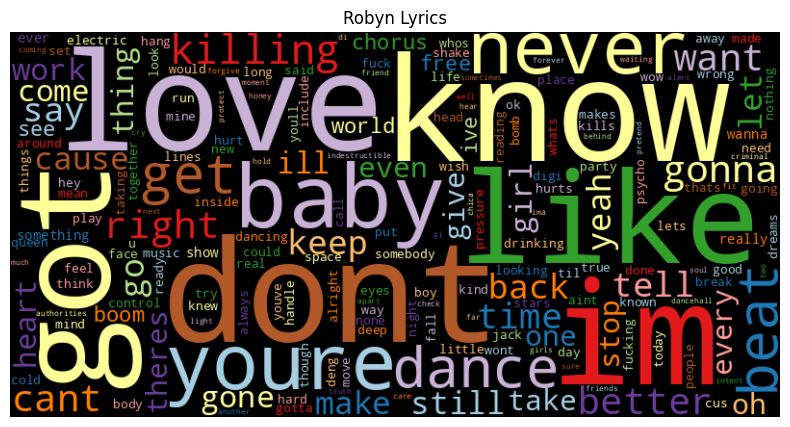

In [96]:
print("Robyn Lyrics Wordcloud:")
wordcloud(robyn_lyrics_freq['freq'], title="Robyn Lyrics")


Cher Twitter Wordcloud:


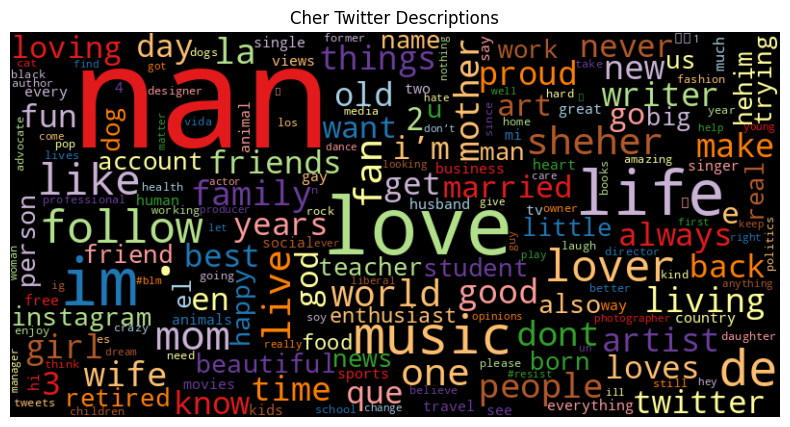

In [97]:
print("Cher Twitter Wordcloud:")
wordcloud(cher_twitter_freq['freq'], title="Cher Twitter Descriptions")



Robyn Twitter Wordcloud:


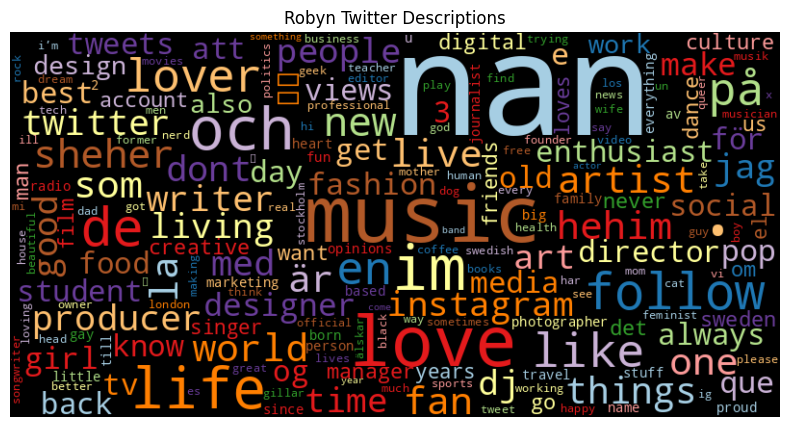

In [98]:
print("Robyn Twitter Wordcloud:")
robyn_twitter_freq_clean = robyn_twitter_freq['freq'].dropna()  # Remove NaNs
wordcloud(robyn_twitter_freq_clean, title="Robyn Twitter Descriptions")

Q: What observations do you have about these (relatively straightforward) wordclouds?

A: We see that the most common words used in each of the corporas are shown as larger words in the word cloud. For Cher, love, dont, know and baby are some of the most frequently used words in her lyrics. For twitter, some reason there is a lot of nan's which I was unable to figure out why this is happening.